# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'INSTALLER'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
display(df.sample(10))

,gender,age,income,family_members,insurance_benefits
2640,1,39.0,42100.0,0,0
3225,1,41.0,38700.0,2,0
1783,0,37.0,50000.0,0,0
3945,1,20.0,35500.0,0,0
2706,1,38.0,35100.0,1,0
2628,0,41.0,45500.0,0,0
2015,1,22.0,30800.0,0,0
3011,1,36.0,68500.0,1,0
512,0,31.0,21700.0,1,0
465,0,46.0,49500.0,0,1


In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

In [7]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:

df['age'] = df['age'].astype(int)

In [8]:
# check to see that the conversion was successful
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


None

In [9]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

display(df.describe())
df = df.drop_duplicates().reset_index()
display(df.head())

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


,index,gender,age,income,family_members,insurance_benefits
0,0,1,41,49600.0,1,0
1,1,0,46,38000.0,1,1
2,2,0,29,21000.0,0,0
3,3,0,21,41700.0,2,0
4,4,1,28,26100.0,0,0


The `'age'` column was changed from float to int and duplicates were removed.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

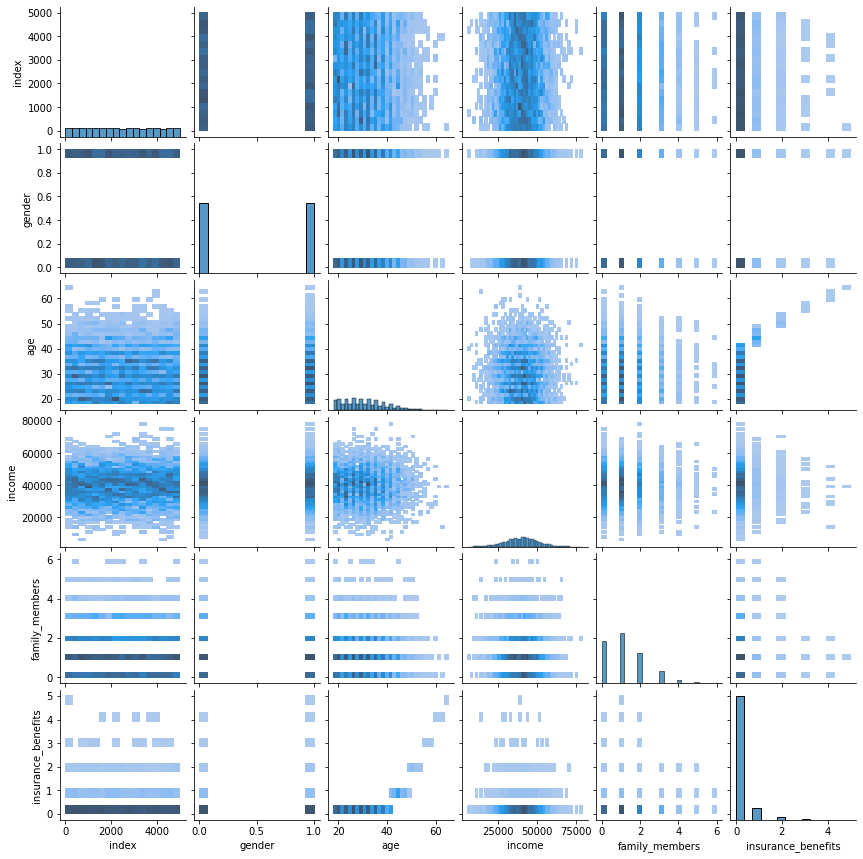

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

In [11]:
# correlation matrix

display(df.corr())

,index,gender,age,income,family_members,insurance_benefits
index,1.000000,-0.003765,0.001165,0.006648,-0.002425,0.004900
gender,-0.003765,1.000000,0.001953,0.015456,-0.007315,0.011565
age,0.001165,0.001953,1.000000,-0.017386,-0.009064,0.654964
income,0.006648,0.015456,-0.017386,1.000000,-0.031687,-0.013123
family_members,-0.002425,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
insurance_benefits,0.004900,0.011565,0.654964,-0.013123,-0.039303,1.000000


**Conclusion**

 - Each observation describes an insurance members details such as, `gender`, `age`, `income`, `family_benefits`, and `insurance_benfits`
they receive.

 - The `age` distribution is right-skewed, and `income` distribution appears to be normally distributed.

 - There are no missing values.

 - There is a moderately strong positive correlation between `age` of insured and `insurance_benfits`.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric=metric).fit(df[feature_names].to_numpy())
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
display(df_scaled.sample(5))

,index,gender,age,income,family_members,insurance_benefits
3311,3400,1.0,0.584615,0.656962,0.500000,0
2596,2651,0.0,0.553846,0.740506,0.166667,0
897,904,0.0,0.630769,0.411392,0.000000,0
200,200,1.0,0.553846,0.292405,0.166667,0
3042,3112,0.0,0.584615,0.482278,0.500000,0


Now, let's get similar records for a given one for every combination

In [16]:
display(get_knn(df, n=5, k=10, metric='euclidean'))

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1,43,41000.0,2,1,0.000000
1965,1995,0,45,41000.0,0,1,3.000000
3860,3972,1,40,41000.0,1,0,3.162278
4617,4763,1,46,41000.0,1,1,3.162278
3695,3801,0,46,41000.0,2,1,3.162278
2700,2759,0,47,41000.0,3,1,4.242641
2659,2717,0,37,41000.0,0,0,6.403124
3344,3434,1,36,41000.0,2,0,7.000000
1716,1740,0,36,41000.0,1,0,7.141428
2812,2876,0,35,41000.0,2,0,8.062258


In [17]:
display(get_knn(df_scaled, n=5, k=10, metric='euclidean'))

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1.0,0.661538,0.518987,0.333333,1,0.000000
1136,1147,1.0,0.646154,0.516456,0.333333,0,0.015592
3955,4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1011,1019,1.0,0.646154,0.501266,0.333333,0,0.023468
2897,2962,1.0,0.630769,0.520253,0.333333,0,0.030795
2097,2128,1.0,0.692308,0.512658,0.333333,1,0.031413
106,106,1.0,0.692308,0.526582,0.333333,1,0.031693
2172,2206,1.0,0.692308,0.530380,0.333333,1,0.032811
2314,2352,1.0,0.692308,0.531646,0.333333,1,0.033271
715,719,1.0,0.630769,0.532911,0.333333,0,0.033773


In [18]:
display(get_knn(df, n=5, k=10, metric='manhattan'))

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1,43,41000.0,2,1,0.0
3695,3801,0,46,41000.0,2,1,4.0
3860,3972,1,40,41000.0,1,0,4.0
4617,4763,1,46,41000.0,1,1,4.0
1965,1995,0,45,41000.0,0,1,5.0
2700,2759,0,47,41000.0,3,1,6.0
3344,3434,1,36,41000.0,2,0,7.0
2812,2876,0,35,41000.0,2,0,9.0
1716,1740,0,36,41000.0,1,0,9.0
2659,2717,0,37,41000.0,0,0,9.0


In [19]:
display(get_knn(df_scaled, n=5, k=10, metric='manhattan'))

,index,gender,age,income,family_members,insurance_benefits,distance
5,5,1.0,0.661538,0.518987,0.333333,1,0.000000
3955,4074,1.0,0.661538,0.501266,0.333333,1,0.017722
1136,1147,1.0,0.646154,0.516456,0.333333,0,0.017916
2897,2962,1.0,0.630769,0.520253,0.333333,0,0.032035
1011,1019,1.0,0.646154,0.501266,0.333333,0,0.033106
2097,2128,1.0,0.692308,0.512658,0.333333,1,0.037098
106,106,1.0,0.692308,0.526582,0.333333,1,0.038364
2172,2206,1.0,0.692308,0.530380,0.333333,1,0.042162
2314,2352,1.0,0.692308,0.531646,0.333333,1,0.043427
715,719,1.0,0.630769,0.532911,0.333333,0,0.044693


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

When the data is scaled the distances become smaller.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results are pretty significantly different. The most interesting difference between the results with scaled and unscaled data is that with scaled data if a feature has a bigger magnitude than others, it has much more weight in the distance calculation. Scaling brings all features on the same footing

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influence the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# calculate the target

df['insurance_benefits_received'] = np.where(df['insurance_benefits'] > 0, True, False)

In [21]:
# check for the class imbalance with value_counts()

display(df['insurance_benefits_received'].value_counts())

False    4284
True      563
Name: insurance_benefits_received, dtype: int64

In [22]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [23]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



In [25]:
train, valid = \
(
    train_test_split(df, stratify=df['insurance_benefits_received'], test_size=0.3, random_state=42)
)
features_train, target_train = train[feature_names], train['insurance_benefits_received']
features_valid, target_valid = valid[feature_names], valid['insurance_benefits_received']

In [54]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape

((3392, 4), (3392,), (1455, 4), (1455,))

In [27]:
def build_model(train, target, test, n_neighbors):
    """
    Fit a model and make predictions
    """
    np.random.seed(42)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(features_train, target)
    y_pred = model.predict(test)
    return y_pred

In [28]:
n_neighbors = 10

# using unscaled data

for k in range(1, n_neighbors+1):
    y_pred = build_model(features_train, target_train, features_valid, k)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.68
Confusion Matrix
[[0.86804124 0.01580756]
 [0.04879725 0.06735395]]

For neighbor k=2
F1: 0.40
Confusion Matrix
[[0.87835052 0.00549828]
 [0.08591065 0.03024055]]

For neighbor k=3
F1: 0.41
Confusion Matrix
[[0.87353952 0.01030928]
 [0.0838488  0.03230241]]

For neighbor k=4
F1: 0.21
Confusion Matrix
[[0.88041237 0.00343643]
 [0.1024055  0.0137457 ]]

For neighbor k=5
F1: 0.22
Confusion Matrix
[[0.8790378  0.004811  ]
 [0.10103093 0.01512027]]

For neighbor k=6
F1: 0.02
Confusion Matrix
[[0.8838488  0.        ]
 [0.11477663 0.00137457]]

For neighbor k=7
F1: 0.05
Confusion Matrix
[[0.88109966 0.00274914]
 [0.11340206 0.00274914]]

For neighbor k=8
F1: 0.03
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [1.14089347e-01 2.06185567e-03]]

For neighbor k=9
F1: 0.03
Confusion Matrix
[[0.88247423 0.00137457]
 [0.11408935 0.00206186]]

For neighbor k=10
F1: 0.02
Confusion Matrix
[[0.8838488  0.        ]
 [0.11477663 0.00137457]]



In [29]:
# reduce the target to either received benefit 1, or not received benefit 0

df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)

In [30]:
train, valid = \
(
    train_test_split(df_scaled, stratify=df_scaled['insurance_benefits_received'], test_size=0.3, random_state=42)
)
features_train, target_train = train[feature_names], train['insurance_benefits_received']
features_valid, target_valid = valid[feature_names], valid['insurance_benefits_received']

In [31]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape

((3392, 4), (3392,), (1455, 4), (1455,))

In [32]:
for k in range(1, n_neighbors+1):
    y_pred = build_model(features_train, target_train, features_valid, k)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.94
Confusion Matrix
[[0.8790378  0.004811  ]
 [0.00824742 0.10790378]]

For neighbor k=2
F1: 0.91
Confusion Matrix
[[0.88109966 0.00274914]
 [0.01786942 0.09828179]]

For neighbor k=3
F1: 0.92
Confusion Matrix
[[0.87697595 0.00687285]
 [0.01168385 0.10446735]]

For neighbor k=4
F1: 0.89
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [2.33676976e-02 9.27835052e-02]]

For neighbor k=5
F1: 0.91
Confusion Matrix
[[0.87972509 0.00412371]
 [0.01580756 0.10034364]]

For neighbor k=6
F1: 0.88
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [2.40549828e-02 9.20962199e-02]]

For neighbor k=7
F1: 0.91
Confusion Matrix
[[0.88247423 0.00137457]
 [0.01718213 0.09896907]]

For neighbor k=8
F1: 0.89
Confusion Matrix
[[0.8838488  0.        ]
 [0.02268041 0.09347079]]

For neighbor k=9
F1: 0.91
Confusion Matrix
[[8.83161512e-01 6.87285223e-04]
 [1.92439863e-02 9.69072165e-02]]

For neighbor k=10
F1: 0.88
Confusion Matrix
[[0.8838488  0.        ]
 [0.02542955 0.09072165]]



 - Comparing KNearestNeighbhors between unscaled and scaled data shows a huge difference in the F1 score. The lowest F1 score produced by any model using scaled features is 88%, whereas for unscaled features it is 0.02. Clearly, showing how the use of distance metric during fitting impacts predictions by large valued features (in this case income).
 - The scaled model surpasses the dummy model.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([X.shape[0], 1]), X, axis=1)
        y_pred = np.dot(X2, self.weights)
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [35]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


In [36]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736673  2.32727489  0.01955949  0.04624156 -0.07297105]
RMSE: 0.36
R2: 0.66


Only 66% of the variance is explained by the features when the data is unscaled. There is no difference in either the RMSE or R2 score post scaling. This is expected as LinearRegression makes predictions using the units of the output, making the necessary adjustments to the units of the features.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [37]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [38]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [39]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [40]:
display(np.dot(P, np.linalg.inv(P)))

array([[ 1.00000000e+00, -1.69848573e-16, -7.58122972e-17,
        -1.13112497e-16],
       [-6.94895396e-17,  1.00000000e+00, -7.10568689e-17,
         3.59096970e-17],
       [-1.21269339e-16, -8.01461326e-17,  1.00000000e+00,
         4.30764008e-19],
       [-3.60694539e-16, -5.55430227e-16,  3.08072404e-16,
         1.00000000e+00]])

In [41]:
display(np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P)))

True

In [42]:
display(np.dot(X, P))

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you guess the customers' ages or income after the transformation?

 - It is clear, the data is indecipherable.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [43]:
display(pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head())

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.611792e-12,46.0,38000.0,1.000000e+00
2,-2.548671e-12,29.0,21000.0,1.008743e-14
3,-5.059112e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.213530e-14


We are able to recover the original matrix X after matrix multiplication of the results of X * P with the inverse of P, but without knowing P it would be very hard.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [44]:
# original data

display(pd.DataFrame(X, columns=feature_names).head())

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


In [45]:
# the transformed one

display(pd.DataFrame(np.dot(X, P), columns=feature_names).head())

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


In [46]:
# the reversed (recovered) one


display(pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head())

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-4.611792e-12,46.0,38000.0,1.000000e+00
2,-2.548671e-12,29.0,21000.0,1.008743e-14
3,-5.059112e-12,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,1.213530e-14


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

 - The reason for the recovered matrix not exactly matching the original is due to floating point errors. There are only a finite number of bits allocated to storing real numbers.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Analytical proof**

Given: $$
w_P = [(XP)^T XP]^{-1} (XP)^T y 
$$

By reversivity of the transpose of a product of matrices, we have
$$
w_P = [(XP)^T XP]^{-1} P^{T}X^{T} y 
$$

Rearranging the terms inside the square brackets, we have
$$
w_P = [P^{T}X^{T}XP]^{-1} P^{T}X^{T} y
$$

Expanding the term inside the square brackets, we have
$$
w_P = P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T} y
$$

Using multiplicative identity, we know $$ (P^{T})^{-1}P^{T} = P^{T}(P^{T})^{-1} = I $$
Therefore, the equation reduces to
$$
w_P = P^{-1}(X^{T}X)^{-1}IX^{T} y
$$

We can see that 
$$
w = (X^{T}X)^{-1}X^{T} y
$$

Substitute w in the above equation, we have
$$
w_P = P^{-1}w
$$

We know that
$$
y = Xw
$$

The prediction of 
$$
y_{P} = X_{P}w_{P}
$$

Subsitute $$ w_{P} $$

In the above euqation, we get
$$
y_{P} = X_{P}(P^{-1}w)
$$

From obsfuscating the input X, we have
$$
X_{P} = XP
$$

Subsititute this in the above equation, we have
$$
y_{P} = XPP^{-1}w
$$

From multiplicative identity, we know $$ (P^{T})^{-1}P^{T} = P^{T}(P^{T})^{-1} = I $$

Therefore, we are left with
$$
y = y_{P} = Xw
$$

 - The analytical proof shows that there should be no impact to the quality of regression, as the results after obfuscation is the same as it would have been without it.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Draw $P$ from a uniform distribution.
- Use $XP$ as the new feature matrix

In [47]:
def generate_square_matrix(num_features, seed=42):
    """
    Generate a square matrix from a uniform distribution
    """
    rng = np.random.default_rng(seed=seed)
    return rng.random(size=(num_features, num_features))

In [48]:
P = generate_square_matrix(4, seed=1234)

In [49]:
def is_invertible(P):
    """
    Check if P is invertible or not
    """
    return np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

In [50]:
display(is_invertible(P))

True

In [51]:
# using the original data but ofuscated

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736747 -0.08612857 -0.09935604  0.15099254  0.06991959]
RMSE: 0.36
R2: 0.66


In [52]:
# using the scaled data but ofuscated

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736673  0.36150371 -1.23349037  3.3150945  -2.35958849]
RMSE: 0.36
R2: 0.66


# Conclusions

 - The results show that even after obfuscating the data, the RMSE and R2 score from the Linear Regression model
are identical; this is independent of whether the data is scaled or not.

**Summary**

- We used KNearestNeighbhors to find the customer closest to a given customer; the solution was improved with scaling
the data, and using the Euclidean metric to improve the predictions.

- We also built models to help the marketing team predict whether a customer will likely recieve insurance benefits or not. And, the resulting model with scaled data, performed very well compared to a dummy model. The resulting model produced had an F1 score of 92% on the validation set.

- We built a LinearRegression model on both scaled and unscaled data, to predict the number of insurance benefits a new customer would receive; the model produced a moderately high R2 score 66%. What we have observed is that scaling didn't impact the results.

- We obfuscated the data, and showed analytically that there is no difference between the obfuscated data and the original data.

- We also proved this computationally, by building a LinearRegression model using the obfuscated data, and the resulting RMSE and R2 scores were identical to that obtained with modeling the original data.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>